In [1]:
### Step-lenght
### sum of angles
### Number of spikes

In [2]:
from src.utile import *
from src.metrics import *
from src.visualisation import *
from src.activity_plotting import *
from src.global_calculations import *
from src.feeding import *
import numpy as np
import matplotlib.pyplot as plt
import time
import math
%load_ext autoreload
%autoreload 2
%load_ext line_profiler
is_feeding=True

In [3]:
cameras = get_camera_names(is_feeding=is_feeding)
days = get_days_in_order(is_feeding=is_feeding)
camera, day = cameras[0], days[0]
print(camera, day)
batches = csv_of_the_day(camera, day, drop_out_of_scope=True, is_feeding=is_feeding)
BLOCK, DIR_CSV_LOCAL

23442333 20210911_1400


('block1',
 '/Volumes/Extreme_SSD/FE_tracks_original/FE_tracks_060000/FE_tracks_060000_block1')

In [4]:
fish_id = 11
camera, pos = fish2camera[fish_id]
print(pos, camera)
is_back = pos==BACK
day_idx = 1
day = days[day_idx]
bdf = csv_of_the_day(camera, day, is_back=is_back,is_feeding=is_feeding)
bdf_f = csv_of_the_day(camera, day, is_back=not is_back, is_feeding=is_feeding)
batch = bdf[day_idx]
batch_f = bdf_f[day_idx]

back 23520264


In [ ]:
s,n = global_activity(list(range(len(fish2camera))), days)
means = [sum(si)/sum(ni) for si,ni in zip(s,n)]
stds = [global_sd([fid], days, mi) for fid,mi in zip(range(len(fish2camera)),means)]
m_s = np.array([means, stds]).T

In [19]:
def update_livehistory_means_and_std(m_s):
    path, filename ="/Volumes/data/loopbio_data/FE_(fingerprint_experiment)_SepDec2021", "DevEx_fingerprint_activity_lifehistory.csv"
    fileupdate = "DevEx_fingerprint_activity_lifehistory_update.csv"
    columns_m_s=["mean_activity", "std_activity", "fish_id"]
    info_df = pd.read_csv("%s/%s"%(path, filename), delimiter=";")
    block1_m_s = pd.read_csv("%s/%s"%(path, fileupdate), delimiter=";")
    block1_m_s=block1_m_s[block1_m_s["block"]==1][columns_m_s].to_numpy()
    m_s_df = np.concatenate((m_s,get_fish_ids()[:,:1]), axis=1)
    m_s_df = pd.DataFrame(np.concatenate((m_s_df, block1_m_s), axis=0), columns=columns_m_s)
    df_update = pd.merge(info_df, m_s_df, on="fish_id",how="left")
    df_update.to_csv("%s/%s"%(path, fileupdate), sep=";")

In [24]:
print(get_fish_ids())

['m1_01' 'm3_01' 'm1_21' 'm1_22' 'm1_03' 'm1_04' 'm2_02' 'm1_12' 'm2_03'
 'm1_16' 'm3_02' 'm2_04' 'm1_13' 'm1_14' 'm1_07' 'm1_08' 'm1_19' 'm1_20'
 'm1_23' 'm1_24' 'm1_09' 'm1_10' 'm1_05' 'm2_01']


In [28]:
56/95*5


2.9473684210526314

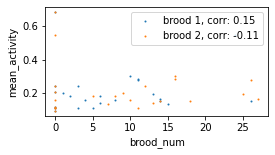

In [131]:
def brood_activity_correlation(livehistory_df):
    df_u = livehistory_df[livehistory_df["block"]==1][["mean_activity", "brood1_num", "brood2_num"]].fillna(0)
    mean_activity = df_u["mean_activity"].to_numpy(dtype=np.float32)
    b1, b2 = df_u["brood1_num"].to_numpy(), df_u["brood2_num"].to_numpy()
    ax = plt.plot( b1,mean_activity, "o", label="brood 1, corr: %.2f"%np.corrcoef((mean_activity, b1))[0,1])
    ax = plt.plot( b2,mean_activity, "o", label="brood 2, corr: %.2f"%np.corrcoef((mean_activity, b2))[0,1])
    plt.ylabel("mean_activity")
    plt.xlabel("brood_num")
    plt.legend()
    plt.savefig("data/brood_activity_correlation.pdf", bbox_inches='tight')
    
brood_activity_correlation(df_update)

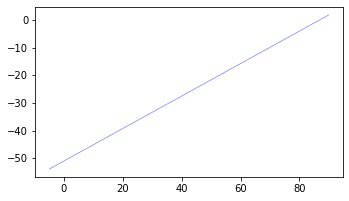

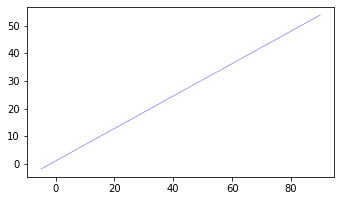

In [7]:
tra = FeedingTrajectory()

In [82]:
tra.plots_for_tex(list(range(tra.N_fishes)), get_days_in_order(is_feeding=True))

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/Extreme_SSD/FE_tracks_original/FE_tracks_140000/FE_tracks_140000_block1/FE_140000_tracks_block1_front'

In [9]:
tra.feeding_data_to_csv()

In [81]:
tra.feeding_data_to_tex()

<BarContainer object of 24 artists>

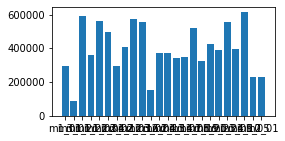

In [19]:
feeding_fish = np.array([sum(ft.values()) for ft in tra.feeding_times])
plt.bar(get_fish_ids(),feeding_fish)

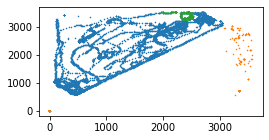

In [69]:
plt.plot(batch["xpx"], batch["ypx"], "*")
plt.plot(batch_f["xpx"], batch_f["ypx"], "*")
feed_b,b = feeding_data(batch, fish_id)
plt.plot(feed_b["xpx"], feed_b["ypx"], "*")
feed_f,b= feeding_data(batch_f, 1)
plt.plot(feed_f["xpx"], feed_f["ypx"], "*")

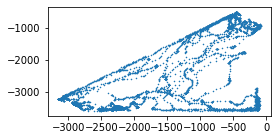

In [602]:
rot = lambda t: np.array([[np.cos(t), -np.sin(t)], [np.sin(t), np.cos(t)]])
r = rot(np.pi)
trans = r.dot(batch[["xpx", "ypx"]].to_numpy().T)
plt.plot(*trans, "*")

#plt.plot(*batch[["x", "y"]].to_numpy().T, "s")
#plt.plot(*np.array([[ 3266.1262223,  -1621.39584926],[59.61836624, -24.03658104]]).T, "o")



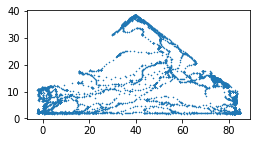

In [603]:
plt.plot(batch.x, batch.y, "*")

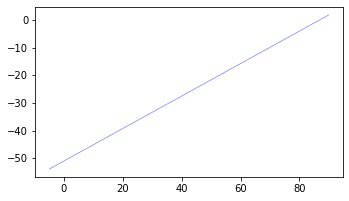

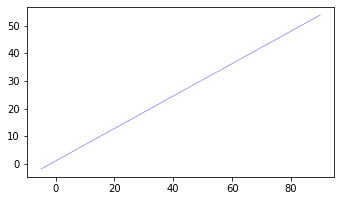

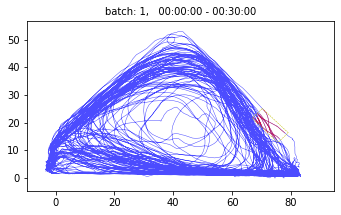

In [36]:
from src.visualisation import Trajectory
from src.feeding import FeedingTrajectory
FT = FeedingTrajectory()
fig = FT.subplot_function(batch, day, "./feeding", "feeding",fish_id, is_back=is_back)
fig

In [139]:
def find_rot_tras(px, cm):
    """
    @params: px, cm: np.array 2x2 row-wise
    returns: R rotation-translation matrix to map from pixels to centimeter coordinates. 
    """
    n = px.shape[0]
    px_dist = abs(px[1]-px[0])
    cm_dist = abs(cm[-1]-cm[0])
    fraq = cm_dist/px_dist
    #px = px * fraq
    px_center = px.sum(axis=0)*(1/px.shape[0])
    cm_center = cm.sum(axis=0)*(1/cm.shape[0])
    
    H = (px-px_center).T@(cm-cm_center)
    U, S, V = np.linalg.svd(H)
    R = V@U.T
    px_t = (R@px.T).T
    px_dist_t = abs(px_t[-1]-px_t[0])
    T = np.diag((cm_dist/px_dist_t))
    if np.linalg.det(R) < 0:
        U,S,V = np.linalg.svd(R)    # multiply 3rd column of V by -1
        V[:,-1]=V[:,-1]*-1
        R = V @ U.T
        
    trans = cm_center - T@(R@px_center)
    return T@R, trans, S
    
cm_1 = np.array([[27.955070, -10.854193], [41.382450, -6.714770], [59.180481,-24.344660]])
px_1 = np.array([[1905.0, 823.0],[2144.0, 1425.0], [3455.0,1135.0]])
R, t, S = find_rot_tras(px_1, cm_1)
print(((R@px_1.T).T+t),"\n")
print(R,S, t)


[[ 28.51250045 -11.93365315]
 [ 40.2675891   -4.5558497 ]
 [ 59.73791145 -25.42412015]] 

[[ 0.01762323  0.01253013]
 [-0.01214065  0.01707545]] [28974.09538068  3065.79137522] [-15.3720528  -2.8588087]


array([[ 25.01227839, -10.62315279],
       [ 38.84806457,  -6.66678592]])

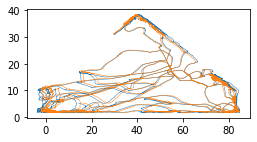

In [592]:
from src.feeding import pixel_to_cm, pixel_to_cm2
#def figure_feeding(fig, feeding_patches, is_back):
    
    ##if is_back:
rot = lambda t: np.array([[np.cos(t), -np.sin(t)], [np.sin(t), np.cos(t)]])
r = rot(-np.pi/4)

test_patch = np.array([1905.0, 823.0, 2144.0, 1425.0]) # in px shoud be 27.955070, -10.854193, 41.382450, -6.714770 in cm 
test_patch1 = np.array([2144.0,1425.0, 2144.0, 1425.0]) ## 41.382450, -6.714770
# p1 40.110401 	-14.413207 	2432.0 	1023.0
# p2 59.180481 	-24.344660 	3455.0 	1135.0
test_patch2 = np.array([2432.0, 1023.0, 3455.0, 1135.0])
def pixel_to_cm3(patch, batch):
    px, cm = batch[["xpx", "ypx"]].to_numpy(), batch[[ "x", "y"]].to_numpy()
    i_start = 0
    i_end = 0
    for i in range(i_start,len(cm)):
        if np.all(np.abs(cm[i]-cm[i_start])>10): 
            i_end = i
            break
    # ---------------
    R, t,S = find_rot_tras(px, cm)
    return (R@patch).T + t

batchT = pixel_to_cm(batch_f[["xpx", "ypx"]].to_numpy().T)
plt.plot(*batchT.T)
plt.plot(*batch_f[["x", "y"]].to_numpy().T)
plt.savefig("exp.pdf")
pixel_to_cm(test_patch.reshape((2,2),order="F"))

In [444]:
rot(np.pi/4)

array([[ 0.70710678, -0.70710678],
       [ 0.70710678,  0.70710678]])

In [525]:
a = np.load(dir_back+"/23484201/20210911_140000.23484201/000000.npz")

In [539]:
for col in ['imgshape', 'chunksize', 'extension', 'format', 'imgdtype', 'created_utc', 'frame_time', 'encoding', 'version', 'frame_number', 'timezone_local', 'class', 'uuid']:
    print(col,": ",a[col])

imgshape :  [3648 3648]
chunksize :  10000
extension :  b'.mp4'
format :  b'nvenc-slow-yuv420'
imgdtype :  b'uint8'
created_utc :  b'2021-09-11T12:00:00.017537'
frame_time :  [1.6313616e+09 1.6313616e+09 1.6313616e+09 ... 1.6313636e+09 1.6313636e+09
 1.6313636e+09]
encoding :  b''
version :  2
frame_number :  [7777180 7777181 7777182 ... 7787177 7787178 7787179]
timezone_local :  b'Europe/Berlin'
class :  b'VideoImgStoreFFMPEG'
uuid :  b'19ab119b4d024cdf83e0f0fe3da6d72d'
